# Signal Modulation classification 3
Experiment with architecture and data

**References**:
- [Original SIMC2](https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.html)
- [Convolutional Radio Modulation Recognition Networks](https://arxiv.org/pdf/1602.04105.pdf)
- [Automatic Signal Modulation Recognition based on Deep Convolutional Neural Network](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi8gNXSl5b9AhWn-yoKHRtdCGUQFnoECBIQAQ&url=https%3A%2F%2Fwww.atlantis-press.com%2Farticle%2F125913178.pdf&usg=AOvVaw1NhM3rX7_Ve6yQoFJlmecP)

Mixed dataset v2 - snr [0..30] with step 1. 30k samples per modulation

## Imports

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path
import glob
import time
from scipy import io
from typing import Tuple

sys.path.append("..") # not good
from tools.data import load_data_simc_v1, load_data_radioml_v1

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [18]:
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = False
N_EPOCHS = 12
BATCH_SIZE = 128
# TRAIN_DATA_DIR = "../data/RML2016.10a/RML2016.10a_dict.pkl" # radioml dataset
TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_SNR_mixed_0-30_30k"

# Deployment
# model_name = "simc_2_mixed_0-30_data"
model_name = "simc_3_MIXED_v2"
# MODELS_DIR = f'models_{model_name}_MIXED_0-30_DATA/'
MODELS_DIR = f'models_{model_name}_MIXED_v2/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
snrs = [0, 5, 10, 15, 20, 25, 30]


Explore dataset used in Convolutional Radio Modulation Recognition Networks

In [5]:
reload_module("tools.data")
from tools.data import load_data_simc_v1
# labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR)
labels, data = load_data_simc_v1(
    classes=modulations, 
    path=Path(TRAIN_DATA_DIR), 
    model_dtype=MODEL_DATA_TYPE
)

# Commented code loads mixed datasst 
# snr_to_labels_data = {}
# for snr in snrs:
#     print(f"snr={snr}")
#     labels, data = load_data_simc_v1(
#         classes=modulations, 
#         path=Path(TRAIN_DATA_DIR) / f"train_data_SIMC1_2k_SNR_{snr}", 
#         model_dtype=MODEL_DATA_TYPE
#     )
#     snr_to_labels_data[snr] = (labels, data)


100%|██████████| 11/11 [02:08<00:00, 11.69s/it]


[debug] Loaded train data with size 337920000 in 128.58898901939392s


In [6]:
print(modulations)
print(labels.shape)
print(data.shape)

# crmrn_ds_keys = list(crmrn_ds.keys())
# print(crmrn_ds_keys)
# print(len(crmrn_ds.keys())) # 20 (snr -20 to 20 with step 2) * 11
# for key in crmrn_ds:
#     print(len(crmrn_ds[key]), end=", ")
# print()
# print(crmrn_ds[list(crmrn_ds.keys())[0]].shape)

['16QAM', '64QAM', '8PSK', 'B-FM', 'BPSK', 'CPFSK', 'DSB-AM', 'GFSK', 'PAM4', 'QPSK', 'SSB-AM']
(330000,)
(330000, 1, 1024, 2)


### Data preprocessing

There are 27_500 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [7]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [8]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [14]:
# Should save some memory
del data
del labels

## Model creation


In [9]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta

def create_model_original():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    BN1 = layers.BatchNormalization(epsilon=0.000010, name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)
    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)

    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = layers.BatchNormalization(epsilon=0.000010, name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)
    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)

    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = layers.BatchNormalization(epsilon=0.000010, name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)
    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)

    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = layers.BatchNormalization(epsilon=0.000010, name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)
    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)

    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = layers.BatchNormalization(epsilon=0.000010, name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)

    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = layers.BatchNormalization(epsilon=0.000010, name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_simc_2():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_simc_3_stable():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(32, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(48, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

In [10]:
model = create_model_simc_3_stable()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       544       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 re_lu (ReLU)                (None, 1, 1024, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 512, 32)       0         
 )                                                               
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 48)        12336     
                                                             

In [11]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)



In [13]:
def step_decay(epoch):
    lrate = 0.02
    factor = epoch // 9
    lrate /= (10**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

# N_EPOCHS = 16 
# BATCH_SIZE = 256
N_EPOCHS = 20
BATCH_SIZE = 256
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[lrate]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


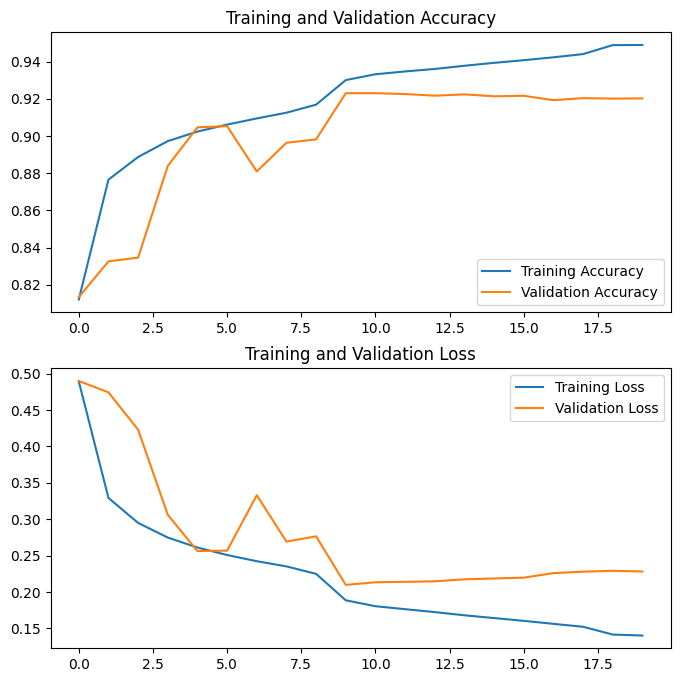

In [18]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [19]:
test_preds = model.predict(test_data)

1032/1032 [==============================] - 3s 2ms/step


In [20]:
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels[0:10])
print(test_labels[0:10])

[ 2  5  2  2  2  0 10  3  6  9]
[ 0  5  2  2  2  0 10  3  6  9]


Overall test accuracy: 0.9173333333333333
16QAM test accuracy: 0.9169583200763601
64QAM test accuracy: 0.9737196765498652
8PSK test accuracy: 0.7773359840954275
B-FM test accuracy: 1.0
BPSK test accuracy: 0.8128519377277245
CPFSK test accuracy: 1.0
DSB-AM test accuracy: 0.9274834437086092
GFSK test accuracy: 0.9900332225913622
PAM4 test accuracy: 0.8798798798798799
QPSK test accuracy: 0.9315514993481095
SSB-AM test accuracy: 0.8868501529051988


<Axes: >

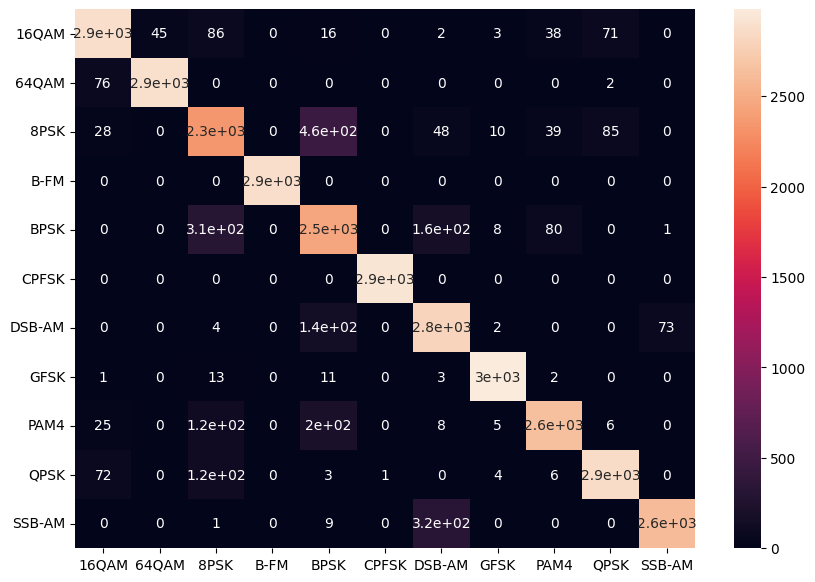

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [39]:
snrs = list(range(0, 30))
def snr_by_idx(idx):
    snr_idx = (idx % 30000) // 1000
    return snrs[snr_idx]
    # try:
    # except IndexError:
    #     print(snr_idx)
    #     print(idx)
    #     raise


In [42]:
print(test_indecies[:40])
test_snrs = np.array([snr_by_idx(idx) for idx in test_indecies])
print(test_snrs[:40])
print(test_indecies.shape)

[  8493 161468  63562  69654  77698   5653 312027  90606 189301 289967
  80714 313356 152259 293836  89863  27984 117193  35360 300975 104524
 297767 208144 224251 132536  97298  99682 131015 241174 200210 168923
 296635 239579 312609  95164  13693 295779  33245  67951  60293  54139]
[ 8 11  3  9 17  5 12  0  9 19 20 13  2 23 29 27 27  5  0 14 27 28 14 12
  7  9 11  1 20 18 26 29 12  5 13 25  3  7  0 24]
(33000,)


In [57]:
snr_to_acc = {}
for snr in range(0, 30):
    cur_test_indecies = np.where(test_snrs == snr)[0]
    cur_test_data = test_data[cur_test_indecies]
    cur_test_labels = test_labels[cur_test_indecies]
    cur_pred = model.predict(cur_test_data, verbose=0)

    cur_pred_labels = np.argmax(cur_pred, axis=1)
    print(f"snr={snr}")
    acc = accuracy_score(cur_test_labels, cur_pred_labels)
    print(f"Overall test accuracy: {acc}")
    snr_to_acc[snr] = acc


snr=0
Overall test accuracy: 0.9044943820224719
snr=1
Overall test accuracy: 0.9084444444444445
snr=2
Overall test accuracy: 0.9174573055028463
snr=3
Overall test accuracy: 0.9108818011257036
snr=4
Overall test accuracy: 0.9157706093189965
snr=5
Overall test accuracy: 0.912848158131177
snr=6
Overall test accuracy: 0.9236234458259325
snr=7
Overall test accuracy: 0.9237057220708447
snr=8
Overall test accuracy: 0.905693950177936
snr=9
Overall test accuracy: 0.9329805996472663
snr=10
Overall test accuracy: 0.9185938945420906
snr=11
Overall test accuracy: 0.93327239488117
snr=12
Overall test accuracy: 0.9119496855345912
snr=13
Overall test accuracy: 0.9207479964381122
snr=14
Overall test accuracy: 0.9240265906932573
snr=15
Overall test accuracy: 0.9133211678832117
snr=16
Overall test accuracy: 0.9095744680851063
snr=17
Overall test accuracy: 0.9264184397163121
snr=18
Overall test accuracy: 0.9289012003693444
snr=19
Overall test accuracy: 0.9283720930232559
snr=20
Overall test accuracy: 0.91

(0.0, 1.0)

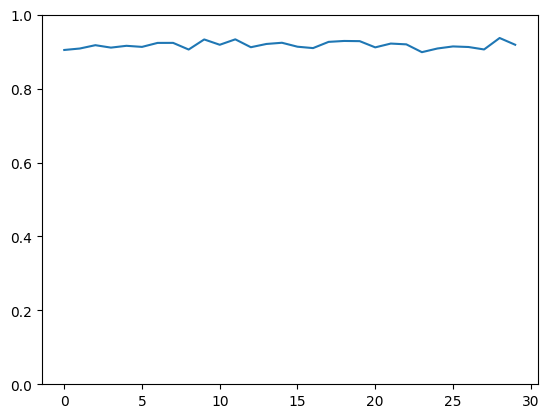

In [61]:
plt.plot(list(snr_to_acc.keys()), list(snr_to_acc.values()))
plt.ylim([0, 1])

(0.0, 1.0)

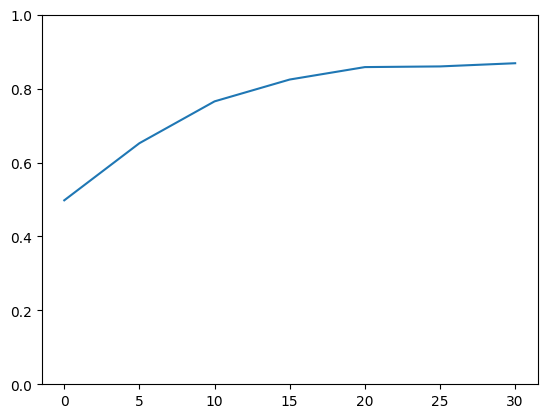

In [63]:
plt.plot([0, 5, 10, 15, 20, 25, 30], [0.49772727272727274 ,0.6522727272727272, 0.7654545454545455, 0.8245454545454546, 0.8581818181818182, 0.86, 0.8686363636363637])
plt.ylim([0, 1])

### Mode deployment

In [46]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_2_MIXED_v2_MIXED_v2/model/assets


INFO:tensorflow:Assets written to: models_simc_2_MIXED_v2_MIXED_v2/model/assets


In [47]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

1545588

In [48]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [15]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000]
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 1, 1024, 2)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


409296

In [16]:
from tools.deployment_tools import predict_tflite

test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [51]:
pred_labels_quant = np.argmax(test_preds_quant, axis=1)
print(pred_labels_quant[:10])
print(test_labels[:10])

[ 2  5  2  2  2  0 10  3  6  9]
[ 0  5  2  2  2  0 10  3  6  9]


Overall test accuracy: 0.9146969696969697
16QAM test accuracy: 0.9121858097359211
64QAM test accuracy: 0.9750673854447439
8PSK test accuracy: 0.7992047713717694
B-FM test accuracy: 1.0
BPSK test accuracy: 0.8247764160317986
CPFSK test accuracy: 1.0
DSB-AM test accuracy: 0.9331125827814569
GFSK test accuracy: 0.988704318936877
PAM4 test accuracy: 0.8668668668668669
QPSK test accuracy: 0.8930899608865711
SSB-AM test accuracy: 0.8752973156642881


<Axes: >

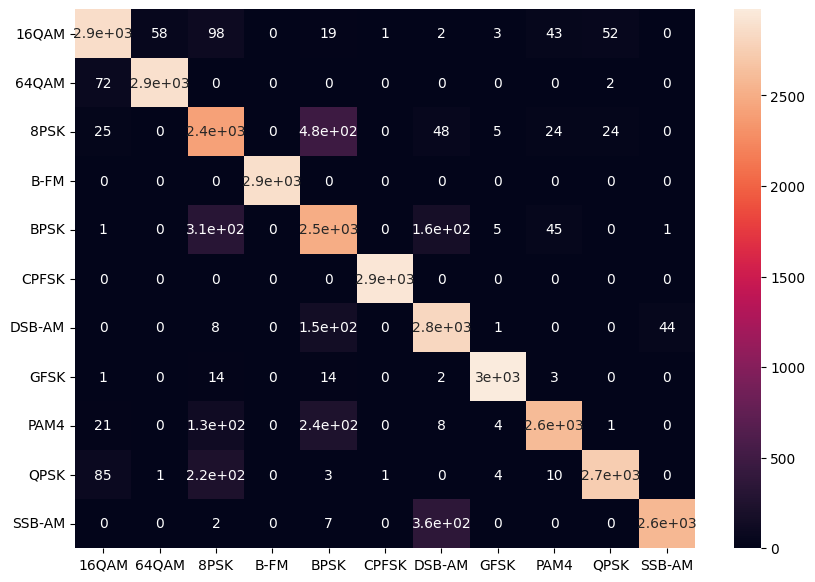

In [52]:
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels_quant[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [53]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.05859375 0.         0.8828125  0.         0.         0.
 0.         0.         0.         0.05859375 0.        ]


In [19]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    # model_no_quant_tflite,
    model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=True,
    epsilon=20,
    apply_quantization=True,
)

[debug] Export test data


11it [00:00, 486.09it/s]
